# Introduction to Convolutional Neural Networks ans Computer Vision with TensorFlow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as a camera of self-driving car recognizng the car in front.

In [1]:
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

## Get Data
The images we-re working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/dansbecker/food-101

However we've modified it to only use two classes (pizza & steak) using the image data modification notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

**Note:** We start with a smaller dataset so we can experiment quickly and figure what works (or better yet what doesn't work) before scaling up.

In [3]:
import requests

import zipfile

import io



# Download the zip file using requests

url = "https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip"

response = requests.get(url)



# Unzip the file in memory and extract it

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:

    zip_ref.extractall("pizza_steak")  # Extract to a folder called 'pizza_steak'

## Inspect the data (become one with it)

A very crucial step at beginning of any machine learning project is becoming one with the data.

And for a computer vision project... this usually means visualizing many samples of your data.

In [2]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk('../data/pizza_steak'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in ../data/pizza_steak
There are 2 directories and 0 images in ../data/pizza_steak\test
There are 0 directories and 250 images in ../data/pizza_steak\test\pizza
There are 0 directories and 250 images in ../data/pizza_steak\test\steak
There are 2 directories and 0 images in ../data/pizza_steak\train
There are 0 directories and 750 images in ../data/pizza_steak\train\pizza
There are 0 directories and 750 images in ../data/pizza_steak\train\steak


In [3]:
# Anather way to find out how many images are in a file
num_steak_images_train = len(os.listdir("../data/pizza_steak/train/steak"))

num_steak_images_train

750

To visualize our images, first let's get the class names programmatically

In [4]:
# Get the classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("../data/pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [5]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # Setup the targeet dirctory (we'll view images from here)
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}") # show the shape of the image

    return img

Image shape: (512, 512, 3)


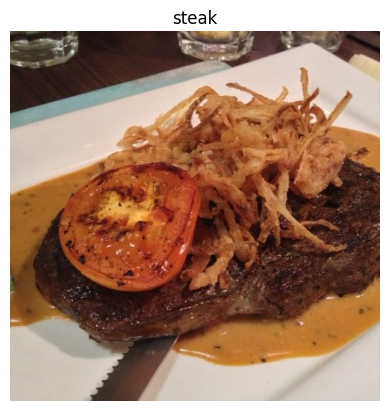

In [6]:
# View the training image from the training dataset
img = view_random_image(target_dir="../data/pizza_steak/train/",
                        target_class="steak")

In [7]:
tf.constant(img)

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 97,  99,  75],
        [ 92,  94,  70],
        [ 88,  88,  64],
        ...,
        [ 36,  22,  22],
        [ 55,  43,  43],
        [ 80,  68,  68]],

       [[ 99, 101,  79],
        [ 93,  95,  73],
        [ 88,  87,  66],
        ...,
        [ 32,  18,  18],
        [ 39,  25,  25],
        [ 47,  35,  35]],

       [[ 93,  95,  74],
        [ 87,  89,  68],
        [ 82,  81,  61],
        ...,
        [ 37,  21,  21],
        [ 32,  16,  16],
        [ 27,  13,  12]],

       ...,

       [[205, 192, 183],
        [204, 191, 182],
        [203, 190, 181],
        ...,
        [212, 205, 195],
        [211, 204, 194],
        [211, 204, 194]],

       [[205, 192, 183],
        [204, 191, 182],
        [203, 190, 181],
        ...,
        [211, 204, 194],
        [211, 204, 194],
        [211, 204, 194]],

       [[205, 192, 183],
        [205, 192, 183],
        [204, 191, 182],
        ...,
        [211, 204, 19

In [8]:
# View the image shape
img.shape # returns width, height, colour channels

(512, 512, 3)

> **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also reffered to as **normilize**) their pixel values by dividing the image arrays by 255. (since 255 is the maximum pixel value). 

## An end-to-end example

Let's build a convolutional neural network to find patterns in our images, more specifically we are need way to:
* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

> Outdated version

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup path to our directory
train_dir = '../data/pizza_steak/train'
test_dir = '../data/pizza_steak/test'

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

print(valid_data.samples)

# Build a CNN model (same as the Tiny VGG on the CNN explainer webside)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),  # Явное указание входной формы
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, padding='valid'),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                       epochs=5,
                       validation_data=valid_data,
                       validation_steps=None
                       )

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
500
Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 282ms/step - accuracy: 0.5504 - loss: 0.7036 - val_accuracy: 0.7740 - val_loss: 0.4826
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - accuracy: 0.7654 - loss: 0.4993 - val_accuracy: 0.8160 - val_loss: 0.4018
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 328ms/step - accuracy: 0.8180 - loss: 0.3956 - val_accuracy: 0.8460 - val_loss: 0.3799
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - accuracy: 0.8157 - loss: 0.3946 - val_accuracy: 0.8460 - val_loss: 0.3322
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - accuracy: 0.8666 - loss: 0.3297 - val_accuracy: 0.8680 - val_loss: 0.3418


> Updated version

In [10]:
# Import tools
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory as Images

# Set seed
tf.random.set_seed(1)

# Set directory
images_dir_train = "../data/pizza_steak/train"
images_dir_test = "../data/pizza_steak/test"

# Load images and split them into batches (NO NEED TO DEFINE HOW MANY CLASSES HERE, SINCE IT WILL BE INFERRED FROM DIRECTORY STRUCTURE AUTOMATICALLY)
# Load images and split them into batches
train_data = Images(
    images_dir_train,
    image_size = (224, 224),
    batch_size = 32
)

test_data = Images(
    images_dir_test,
    image_size = (224, 224),
    batch_size = 32
)

# Set number of classes
num_classes = len(train_data.class_names)

# Build model, indicating Rescaling layer as a first layer
model_1 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

# Compile model
model_1.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

# Train model
history_1 = model_1.fit(
  train_data,
  validation_data=test_data,
  epochs=5
)

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 324ms/step - accuracy: 0.6173 - loss: 0.7413 - val_accuracy: 0.8460 - val_loss: 0.3547
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 390ms/step - accuracy: 0.7959 - loss: 0.4298 - val_accuracy: 0.8540 - val_loss: 0.3331
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 366ms/step - accuracy: 0.8354 - loss: 0.3836 - val_accuracy: 0.8700 - val_loss: 0.3161
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 297ms/step - accuracy: 0.8644 - loss: 0.3206 - val_accuracy: 0.8060 - val_loss: 0.3920
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 290ms/step - accuracy: 0.8805 - loss: 0.2750 - val_accuracy: 0.8540 - val_loss: 0.3319


In [11]:
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,769,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,366,024 (31.91 MB)

 Trainable params: 2,788,674 (10.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,577,350 (21.28 MB)

## Using the same model as before

Let's replicate the model we've build in a previous section to see if it works with our image data.

The model we're building is from Tensorflow playground

In [14]:
# Set random 
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        validation_data=test_data,
                       )

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5076 - loss: 111.1583 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5043 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5097 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5128 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5159 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931


In [15]:
# Get a summary of model_2
model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │         602,116 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,806,425 (6.89 MB)

 Trainable params: 602,141 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,204,284 (4.59 MB)

> Despite having 20x more parameters than our CNN (model_1), model_2 performs terrible. Let's try to improve it.

In [20]:
# Set the random seed
tf.random.set_seed(42)

# Create the model (same as model_2)
model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.6075 - loss: 2475.9028 - val_accuracy: 0.6260 - val_loss: 761.1215
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.6819 - loss: 478.8931 - val_accuracy: 0.7960 - val_loss: 82.1717
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.6437 - loss: 304.1569 - val_accuracy: 0.5140 - val_loss: 714.0807
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.7041 - loss: 230.8508 - val_accuracy: 0.7020 - val_loss: 136.9999
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.7392 - loss: 133.6318 - val_accuracy: 0.6500 - val_loss: 218.0358


In [21]:
# Get the model_3 summary
model_3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 100)                 │      15,052,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,189,305 (172.38 MB)

 Trainable params: 15,063,101 (57.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,126,204 (114.92 MB)

> **Note:** You can think of trainable parameters as **patterns a model can learn from data**, Intuitively, you might think more is better. And in lots of cases, it is. But in this case, the difference here is two different styles of model we're using. Where a series of dense layers has a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, **a CNN seeks to sort out and learn the most important patterns in an image**. So even though these are less learnable parameters in our CNN, these are often more helphul in dechiphering between different **features** in an image.